# 5 - Data association - clutter tutorial
Tracking a single target in the presence of clutter and missed detections

Tracking is frequently complicated by the presence of detections which are not associated with the target of interest. These may range from sensor-generated noise to returns off intervening physical objects, or environmental effects. We refer to these collectively as *clutter* if they have only nuisance value and need to be filtered out.

In this tutorial we introduce the use of data association algorithms in Stone Soup and demonstrate how they can mitigate confusion due to clutter. To begin with we use a **nearest neighbour** method, which is conceptually simple and associates a prediction and a detection based only on their proximity as quantified by a particular metric.

## Background
The principal difficulty in practical multi-object tracking is not usually to do with the state of an individual object. Rather it is to do with the fact that the potential association of measurement to prediction is fraught with ambiguity. To illustrate this point consider a couple of examples:

 <div class="image12">
    <img src="https://stonesoup.readthedocs.io/en/latest/_images/20170705_2x2associationexamples.png" width="300"/>
    <img src="https://stonesoup.readthedocs.io/en/latest/_images/800px-20170607_associations.png" width="300"/>
 <div>

The first (left) is the full set of associations of two targets (crosses) with two measurements (stars). 
* Green: measurement generated by one target only and target capable of generating one measurement only; 
* Yellow: includes measurements generated by more than one target; 
* Pink: includes targets generating more than one measurement. 

The second image (right) shows the number of ways of associating up to 5 targets with up to 10 measurements depending on whether you allow one-to-one (bottom), many-to-one (middle) or many-to-many (top). In this latter instance the number of potential associations *at a single time instance* tops out at $10^{15}$.  

Clearly it would be prohibitive to have to assess each of these options at each timestep. For this reason there exist a number of data association schemes. We'll set up a scenario and then proceed to introduce the nearest neighbour algorithm as a first means to address the association issue.

## Set up a simulation
As in previous tutorials, we start with a target moving linearly in the 2D Cartesian plane.

In [1]:
import numpy as np
from scipy.stats import uniform
from datetime import datetime
from datetime import timedelta

from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

In [2]:
np.random.seed(1991)

start_time = datetime.now().replace(microsecond=0)
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.005),
                                                          ConstantVelocity(0.005)])
timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=timesteps[0])])

for k in range(1, 21):
    timesteps.append(start_time+timedelta(seconds=k))
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))

## Probability of detection
For the first time we introduce the possibility that, at any time-step, our sensor receives no detection from the target (i.e. $p_d < 1$).

In [3]:
prob_det = 0.9

## Simulate clutter
Next generate some measurements and, since $p_{fa} > 0$, add in some clutter at each time-step. We use the `TrueDetection` and `Clutter` subclasses of `Detection` to help with identifying data types in plots later. A fixed number of clutter points are generated and uniformly distributed across a $\pm 20$ rectangular space centred on the true position of the target.

In [4]:
from stonesoup.types.detection import TrueDetection
from stonesoup.types.detection import Clutter
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.array([[0.75, 0],
                          [0, 0.75]])
    )
all_measurements = []
for state in truth:
    measurement_set = set()

    # Generate actual detection from the state with a 1-p_d chance that no detection is received.
    if np.random.rand() <= prob_det:
        measurement = measurement_model.function(state, noise=True)
        measurement_set.add(TrueDetection(state_vector=measurement,
                                          groundtruth_path=truth,
                                          timestamp=state.timestamp,
                                          measurement_model=measurement_model))

    # Generate clutter at this time-step
    truth_x = state.state_vector[0]
    truth_y = state.state_vector[2]
    for _ in range(np.random.randint(10)):
        x = uniform.rvs(truth_x - 10, 20)
        y = uniform.rvs(truth_y - 10, 20)
        measurement_set.add(Clutter(np.array([[x], [y]]), timestamp=state.timestamp,
                                    measurement_model=measurement_model))

    all_measurements.append(measurement_set)

## Plot the ground truth and measurements with clutter.

In [5]:
# Plot ground truth.
from stonesoup.plotter import AnimatedPlotterly
plotter = AnimatedPlotterly(timesteps, tail_length=0.3)
plotter.plot_ground_truths(truth, [0, 2])

# Plot true detections and clutter.
plotter.plot_measurements(all_measurements, [0, 2])

plotter.fig

Text(0.5, 1.0, 'Track Plot')

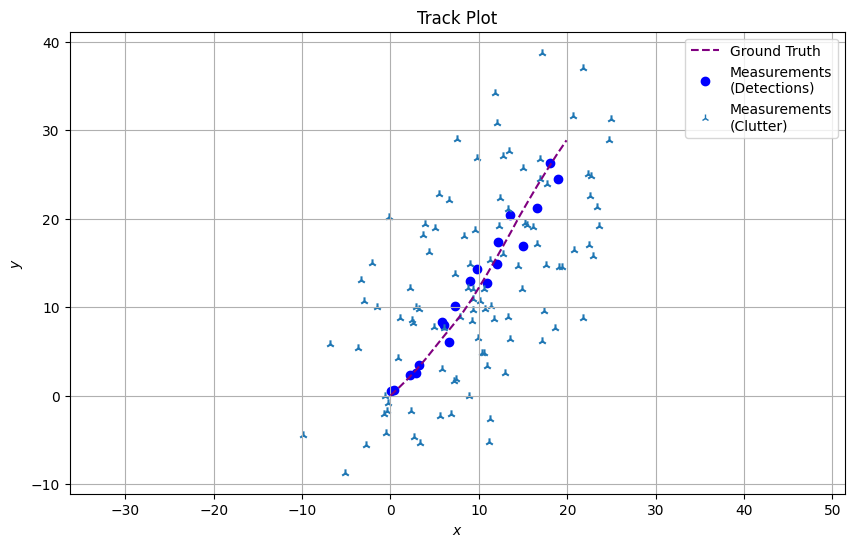

In [6]:
# Plot ground truth.
from stonesoup.plotter import Plotter
from matplotlib import pyplot as plt
static_plotter = Plotter()
static_plotter.plot_ground_truths(truth, [0, 2], color='purple')

# Plot true detections and clutter.
static_plotter.plot_measurements(all_measurements, [0, 2])
plt.grid()
plt.title('Track Plot')

## Distance Hypothesiser and Nearest Neighbour
Perhaps the simplest way to associate a detection with a prediction is to measure a 'distance' to each detection and hypothesise that the detection with the lowest distance
is correctly associated with that prediction.

An appropriate distance metric for states described by Gaussian distributions is the *Mahalanobis distance*. This quantifies the distance of a point relative to a given distribution. In the case of a point $\mathbf{x} = [x_{1}, ..., x_{N}]^T$, and distribution with mean $\boldsymbol{\mu} = [\mu_{1}, ..., \mu_{N}]^T$ and covariance matrix $P$, the Mahalanobis distance of $\mathbf{x}$ from the distribution is given by:

$$
       \sqrt{(\mathbf{x} - \boldsymbol{\mu})^T P^{-1} (\mathbf{x} - \boldsymbol{\mu})}
$$
which equates to the multi-dimensional measure of how many standard deviations a point is away from the mean.

We're going to create a hypothesiser that ranks detections against predicted measurement according to the Mahalanobis distance, where those that fall outside of :math:`3` standard deviations of the predicted measurement's mean are ignored. To do this we create a `DistanceHypothesiser` which pairs incoming detections with track predictions, and pass it a `Measure` class which (in this instance) calculates the Mahalanobis distance.

The hypothesiser must use a predicted state given by the predictor, create a measurement prediction using the updater, and compare this to a detection given a specific metric. Hence, it takes the predictor, updater, measure (metric) and missed distance (gate) as its arguments. We therefore need to create a predictor and updater, and to initialise a measure.

In [7]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=3)

from stonesoup.dataassociator.neighbour import NearestNeighbour
data_associator = NearestNeighbour(hypothesiser)

Now we use the `NearestNeighbour` data associator, which picks the hypothesis pair (predicted measurement and detection) with the highest 'score' (in this instance, those that are closest to each other).

 <div>
 <img src="https://stonesoup.readthedocs.io/en/latest/_images/NN_Association_Diagram.png" width="500"/>
 <div>

 In the diagram above, there are three possible detections to be considered for association (some of which may be clutter). The detection with a score of :math:`0.4` is selected by the nearest neighbour algorithm.

## Run the Kalman filter with the associator
With these components, we can run the simulated data and clutter through the Kalman filter.

In [9]:
# Create prior
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

# Loop through the predict, hypothesise, associate and update steps.
from stonesoup.types.track import Track

track = Track([prior])
n = 0
# for n, measurements in enumerate(all_measurements):
for measurements in all_measurements:
    hypotheses = data_associator.associate([track],
                                           measurements,
                                           start_time + timedelta(seconds=n))
    n += 1
    hypothesis = hypotheses[track]

    if hypothesis.measurement:
        post = updater.update(hypothesis)
        track.append(post)
    else:  # When data associator says no detections are good enough, we'll keep the prediction
        track.append(hypothesis.prediction)

In [10]:
# Plot the resulting track
plotter.plot_tracks(track, [0, 2], uncertainty=True)
plotter.fig